# Imports

In [1]:
import sys
import os
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

from IPython.display import display 


project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from data_collection.data_collector import DataCollector, mt5
from future_inzenering.talib_indicators import TLIndicators



# Getting Data

In [2]:
data_col = DataCollector()
data = data_col.get_historical_data(symbol="EURUSD", timeframe= mt5.TIMEFRAME_M5 )
data.head() 

,Open,Close,High,Low,Volume
Date,,,,,
2024-03-18 05:35:00,1.08898,1.08878,1.08900,1.08875,56
2024-03-18 05:40:00,1.08878,1.08863,1.08878,1.08863,50
2024-03-18 05:45:00,1.08863,1.08861,1.08865,1.08857,72
2024-03-18 05:50:00,1.08861,1.08859,1.08863,1.08853,62
2024-03-18 05:55:00,1.08859,1.08854,1.08860,1.08853,81


#  Functions for creating features

In [3]:
tl_indicators = TLIndicators(data)
t_data = tl_indicators.all_talib_indicators()
t_data.shape

(30000, 225)

In [5]:
def create_lag_features(data:pd.DataFrame, start:int=1, end:int|None=None, 
                        column:str="Close")-> pd.DataFrame:
    """
    Creates lagged features for the specified column of the time series.

    Parameters:
    data (pd.DataFrame): The original DataFrame containing the time series.
    start (int): The starting lag (default 1).
    end (int | None): The ending lag. If None, calculated as half the square root of the series length.
    column (str): The name of the column for which to create lagged features (default "Close").

    Returns:
    pd.DataFrame: The DataFrame with the lagged features added.
    """

    df = data.copy()

    if end is None:
        n = len(data)
        end = int((n / np.sqrt(n)) / 2)

    for lag in range(start, end+1 ):
        df[f'lag_{lag}'] = df[column].shift(lag)

    return df.dropna()

data = create_lag_features(data, end=5).rename(columns={"lag_1":"FLClose"})

In [6]:
def plot(data: pd.Series, smoothed_data: pd.Series, title = ""):
    """
    Plots the original time series and the exponential smoothed values.

    Parameters:
    data (pd.DataFrame): The original DataFrame containing the time series.
    smoothed_data (pd.DataFrame): The DataFrame with smoothed values.
    column (str): The name of the column to plot (defaults to "Close").
    """
    plt.figure(figsize=(14, 7))
    
    # Plot the original data
    plt.plot(data.index, data, label='Original Data', color='blue')
    
    # Plot the smoothed data
    plt.plot(smoothed_data.index, smoothed_data, label='Smoothed Data', color='red', linestyle='--')
    
    # Add titles and labels
    plt.title( title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()


In [7]:
def exponential_smoothing(data: pd.DataFrame, alpha: float=.9, column: str = "FLClose") -> pd.DataFrame: 
    """
    Performs exponential smoothing on a time series.

    Parameters:
    data (pd.DataFrame): The original DataFrame containing the time series.
    alpha (float): The smoothing factor (0 < alpha <= 1).
    column (str): The name of the column to smooth (defaults to "Close").

    Returns:
    pd.DataFrame: A DataFrame with a column of smoothed values ​​added.
    """
    data = data.copy()

    data["ES"] = data[column].ewm(alpha=alpha, adjust=False).mean()

    return data

data = exponential_smoothing(data)

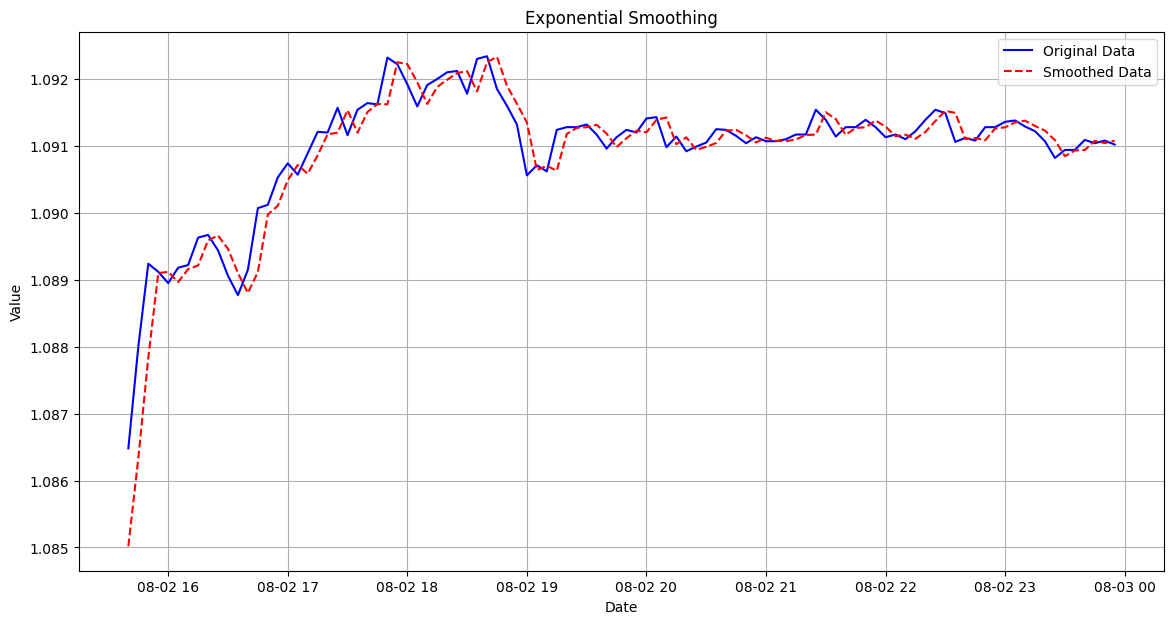

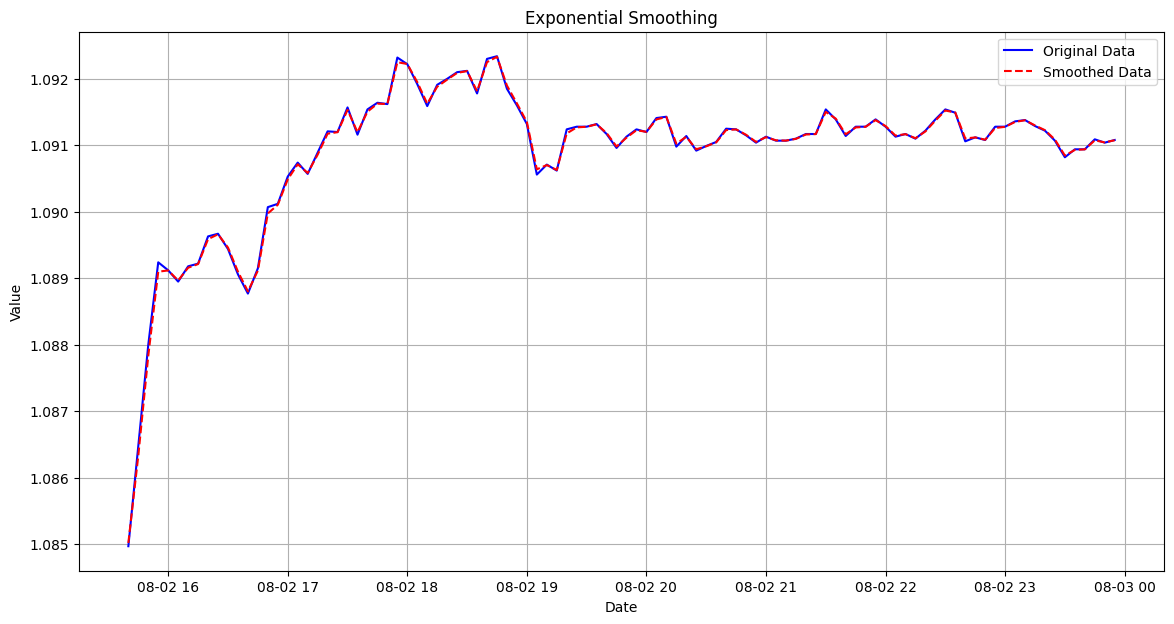

In [8]:

data_len = 100
plot(data["Close"][-data_len:], data["ES"][-data_len:], 'Exponential Smoothing')

plot(data["FLClose"][-data_len:], data["ES"][-data_len:], 'Exponential Smoothing')


In [9]:
def double_exponential_smoothing(data: pd.DataFrame, alpha: float=.9, beta: float=.1, 
                                 column: str = "FLClose") -> pd.DataFrame:
    """
    Performs double exponential smoothing on a time series.

    Parameters:
    data (pd.DataFrame): The original DataFrame containing the time series.
    alpha (float): Smoothing factor for the level (0 < alpha <= 1).
    beta (float): Smoothing factor for the trend (0 < beta <= 1).
    column (str): The name of the column to smooth (defaults to "Close").

    Returns:
    pd.DataFrame: DataFrame with the smoothed column and forecast appended.
    """
    data = data.copy()
    series = data[column].values
    n = len(series)
    result = [series[0]]
    
    # Initialization of level and trend
    level = series[0]
    trend = series[1] - series[0]
    
    for t in range(1, n):
        value = series[t]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    
    # Processing the last forecast
    result.append(level + trend)
    
    
    df = data.copy()
    df["DES"] = result[:n] 

    return df

data = double_exponential_smoothing(data)

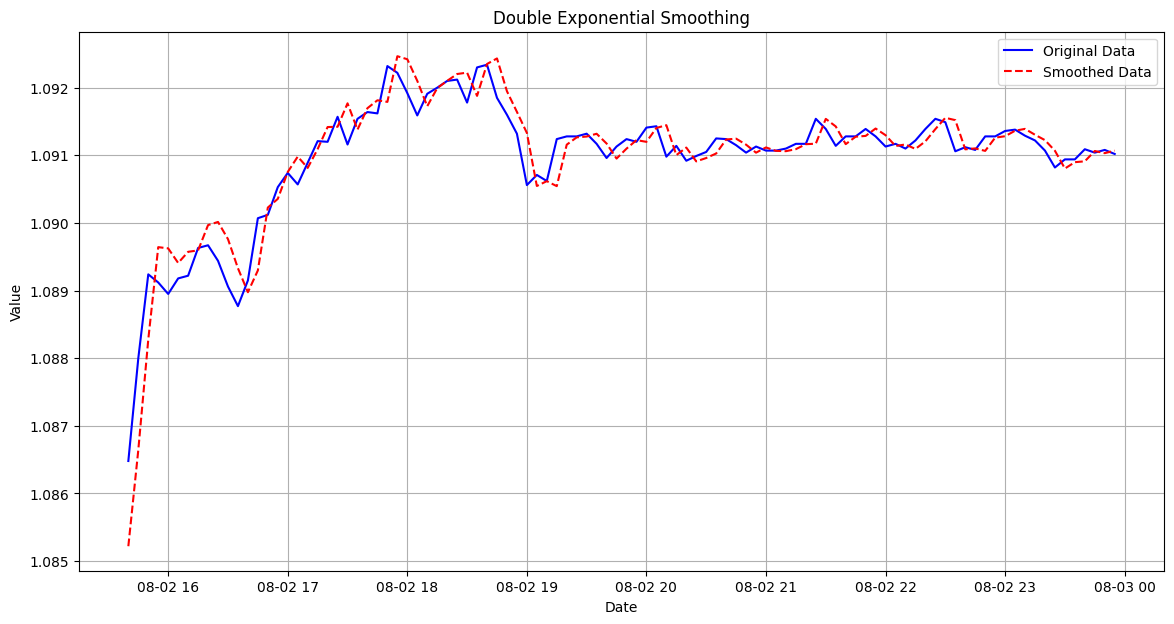

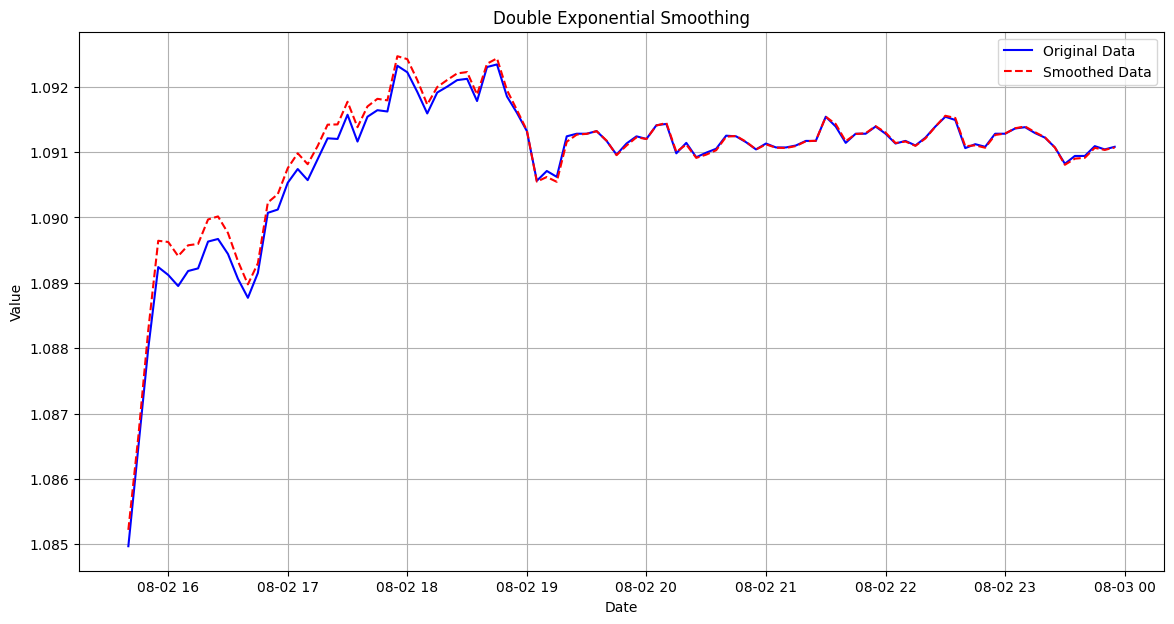

In [10]:
data_len = 100
plot(data["Close"][-data_len:], data["DES"][-data_len:], 'Double Exponential Smoothing')


plot(data["FLClose"][-data_len:], data["DES"][-data_len:], 'Double Exponential Smoothing')

In [11]:
data.head()

,Open,Close,High,Low,Volume,FLClose,lag_2,lag_3,lag_4,lag_5,ES,DES
Date,,,,,,,,,,,,
2024-03-11 05:00:00,1.09386,1.09388,1.09397,1.09383,149,1.09386,1.09381,1.09396,1.09392,1.09390,1.093860,1.093860
2024-03-11 05:05:00,1.09389,1.09380,1.09392,1.09376,158,1.09388,1.09386,1.09381,1.09396,1.09392,1.093878,1.093900
2024-03-11 05:10:00,1.09382,1.09399,1.09400,1.09380,162,1.09380,1.09388,1.09386,1.09381,1.09396,1.093808,1.093821
2024-03-11 05:15:00,1.09400,1.09411,1.09418,1.09397,172,1.09399,1.09380,1.09388,1.09386,1.09381,1.093972,1.093999
2024-03-11 05:20:00,1.09412,1.09416,1.09419,1.09403,153,1.09411,1.09399,1.09380,1.09388,1.09386,1.094096,1.094135


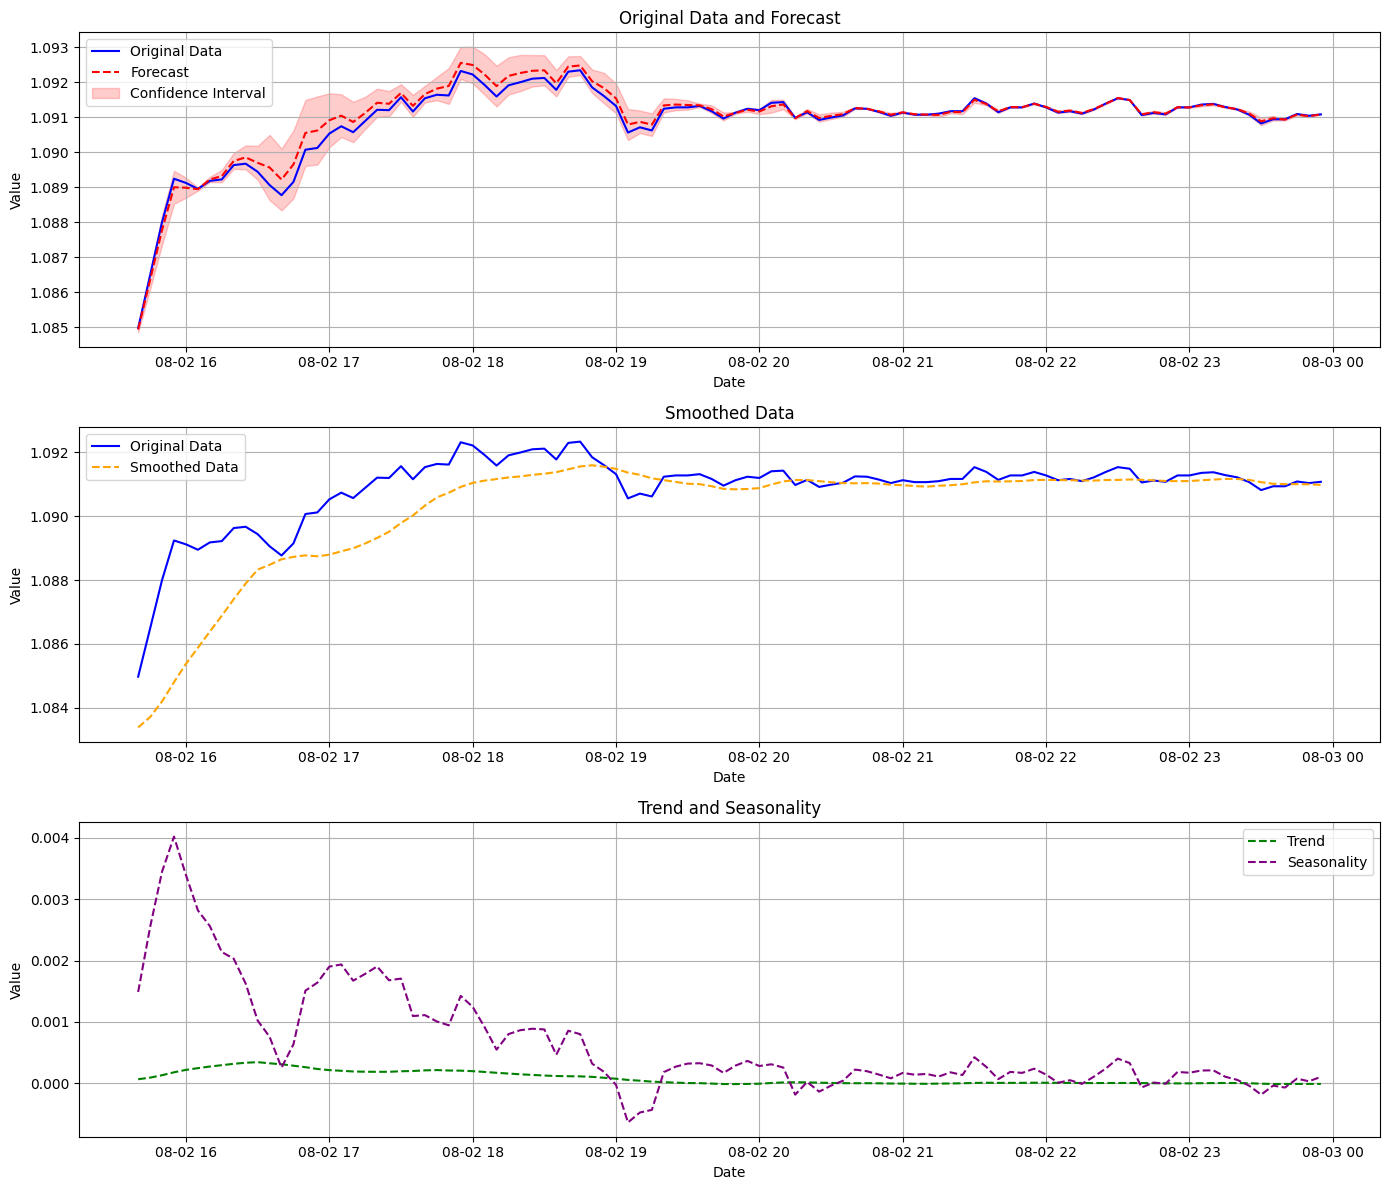

In [13]:
class HoltWinters:
    """
    Holt-Winters model with Brutlag method for anomaly detection.
    """


    def _initial_trend(self) -> float:
        """Initializes the trend based on the first few seasons."""
        sum_trend = 0.0
        for i in range(self._slen):
            sum_trend += float(self._series.iloc[i + self._slen] - self._series.iloc[i]) / self._slen
        return sum_trend / self._slen  

    def _initial_seasonal_components(self) -> dict:
        """Initializes seasonal components."""
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self._series) / self._slen)

        # Calculate seasonal averages
        for j in range(n_seasons):
            season_avg = np.mean(self._series.iloc[self._slen * j:self._slen * j + self._slen])
            season_averages.append(season_avg)

        # Calculate initial seasonal values
        for i in range(self._slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self._series.iloc[self._slen * j + i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg / n_seasons

        return seasonals

    def triple_exponential_smoothing(self, data:pd.DataFrame, column:str= "FLClose", slen:int=12, 
                                     alpha:float=.1, beta:float=.1, gamma:float=0.9, n_preds:int=1, 
                                     scaling_factor:float = 1.96) -> pd.DataFrame:
        """
        Performs triple exponential smoothing and returns a DataFrame with the results,
        predicted values, upper and lower bounds, and model components.

        Triple exponential smoothing includes:

        1. **Level**: the smoothed value of the time series at the current time.

        2. **Trend**: the change in level relative to the previous value.

        3. **Seasonality**: cyclical fluctuations in the data that repeat at a certain periodicity.

        Parameters:
        - data (pd.DataFrame): The time series data containing the column with the time series to analyze.
        - column (str): The name of the column in `data` that contains the time series. Defaults to "Close".
        - slen (int): Season length (number of periods in one season). Determines the periodicity of seasonal fluctuations. Defaults to 24.
        - alpha (float): The smoothing coefficient for the level. The value must be be in the range (0, 1]. Defines the weight for the time series level. Default is 0.5.
        - beta (float): Trend smoothing coefficient. The value must be in the range (0, 1]. Defines the weight for trend. Default is 0.5.
        - gamma (float): Seasonality smoothing coefficient. The value must be in the range (0, 1]. Defines the weight for seasonal variations. Default is 0.5.
        - n_preds (int): Number of steps ahead to forecast. Defines the forecast horizon. Default is 1.
        - scaling_factor (float): Brute-Lag confidence interval width. Defines how wide the confidence interval boundary will be. Default is 1.96 (for a 95% confidence interval).

        Returned value:
        - **Actual** (pd.Series): The actual values ​​of the time series.
        - **Forecast** (pd.Series): The predicted values ​​of the time series as calculated by the model. These are the values ​​the model expects based on the current data and previous estimates.
        - **Predicted_Deviation** (pd.Series): The deviation forecast values ​​calculated by the Brutlag algorithm. This value shows the uncertainty of the forecast.
        - **Upper_Bound** (pd.Series): The upper bound of the forecast confidence interval. It is calculated as the forecast value plus the deviation value multiplied by the scaling factor.
        - **Lower_Bound** (pd.Series): The lower bound of the forecast confidence interval. It is calculated as the forecast value minus the deviation value multiplied by the scaling factor.
        - **Smooth** (pd.Series): Smoothed values ​​of the time series level. These values ​​take into account only the level without trend and seasonality.
        - **Trend** (pd.Series): Estimated trend at each step. It is the change in level over time, taking into account only trends.
        - **Season** (pd.Series): Seasonal components of the model at each step. They show cyclical fluctuations based on pre-calculated seasonal values.

        Notes:
        - The method produces forecasts for both historical data (within the original time series) and future values ​​(within the forecast horizon, `n_preds`).
        - The bias and confidence interval bounds are increased with each forecast step, accounting for forecast uncertainty.
        - The seasonal components and trend are calculated using historical data and the initial values ​​set in the `_initial_trend` and `_initial_seasonal_components` methods.

        The returned DataFrame contains all the listed columns with data corresponding to the length of the time series plus the forecast horizon.

        Return value:
        - **pd.DataFrame**: DataFrame containing columns with actual and forecast values, biases, interval bounds, and model components.

        Example usage: 
        ```python model = HoltWinters() 
        result_df = model.triple_exponential_smoothing() print(result_df.head(15)) ``` 
        """



        self._series = data[column]
        self._column = column
        self._slen = slen
        self._alpha = alpha
        self._beta = beta
        self._gamma = gamma
        self._n_preds = n_preds
        self._scaling_factor = scaling_factor
        
        result = []
        smooth = []
        trend = []
        season = []
        predicted_deviation = []
        upper_bound = []
        lower_bound = []

        seasonals = self._initial_seasonal_components()
        last_smooth = self._series.iloc[0]
        current_trend = self._initial_trend()

        for i in range(len(self._series) + self._n_preds):
            if i == 0:
                smooth_val = self._series.iloc[0]
                result.append(self._series.iloc[0])
                smooth.append(smooth_val)
                trend.append(current_trend)
                season.append(seasonals[i % self._slen])

                predicted_deviation.append(0)

                upper_bound.append(result[0] + self._scaling_factor * predicted_deviation[0])
                lower_bound.append(result[0] - self._scaling_factor * predicted_deviation[0])

                continue

            if i >= len(self._series):
                m = i - len(self._series) + 1
                forecast = (smooth_val + m * current_trend) + seasonals[i % self._slen]
                result.append(forecast)

                # Увеличиваем неопределенность во время прогноза
                predicted_deviation.append(predicted_deviation[-1] * 1.01)
            else:
                value = self._series.iloc[i]
                last_smooth, smooth_val = smooth_val, self._alpha * (value - seasonals[i % self._slen]) + (1 - self._alpha) * (smooth_val + current_trend)
                current_trend = self._beta * (smooth_val - last_smooth) + (1 - self._beta) * current_trend
                seasonals[i % self._slen] = self._gamma * (value - smooth_val) + (1 - self._gamma) * seasonals[i % self._slen]
                forecast = smooth_val + current_trend + seasonals[i % self._slen]
                result.append(forecast)

                # Отклонение рассчитывается по алгоритму Брутлага
                predicted_deviation.append(self._gamma * np.abs(self._series.iloc[i] - result[i]) + (1 - self._gamma) * predicted_deviation[-1])

            upper_bound.append(result[-1] + self._scaling_factor * predicted_deviation[-1])
            lower_bound.append(result[-1] - self._scaling_factor * predicted_deviation[-1])

            smooth.append(smooth_val)
            trend.append(current_trend)
            season.append(seasonals[i % self._slen])

        df = pd.DataFrame({
            'Forecast': result[:len(self._series)],
            'Predicted_Deviation': predicted_deviation[:len(self._series)],
            'Upper_Bound': upper_bound[:len(self._series)],
            'Lower_Bound': lower_bound[:len(self._series)],
            'Smooth': smooth[:len(self._series)],
            'Trend': trend[:len(self._series)],
            'Season': season[:len(self._series)]
        }, index=self._series.index)

        # Merge original data with results
        return pd.merge(data, df, how='inner', left_index=True, right_index=True)

    def plot_triple_exponential_smoothing(self, df: pd.DataFrame, column: str = "FLClose"):
        """
        Plots the results of triple exponential smoothing.

        Parameters:
        df (pd.DataFrame): The DataFrame with the results of triple exponential smoothing.
        column (str): The name of the column to plot (defaults to "Close").
        """
        plt.figure(figsize=(14, 12))

        # Plot the original data
        plt.subplot(3, 1, 1)
        plt.plot(df.index, df[column], label='Original Data', color='blue')
        plt.plot(df.index, df['Forecast'], label='Forecast', color='red', linestyle='--')
        plt.fill_between(df.index, df['Lower_Bound'], df['Upper_Bound'], color='red', alpha=0.2, label='Confidence Interval')
        plt.title('Original Data and Forecast')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)

        # Plot the smoothed values
        plt.subplot(3, 1, 2)
        plt.plot(df.index, df[column], label='Original Data', color='blue')
        plt.plot(df.index, df['Smooth'], label='Smoothed Data', color='orange', linestyle='--')
        plt.title('Smoothed Data')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)

        # Plot the trend and seasonality
        plt.subplot(3, 1, 3)
        plt.plot(df.index, df['Trend'], label='Trend', color='green', linestyle='--')
        plt.plot(df.index, df['Season'], label='Seasonality', color='purple', linestyle='--')
        plt.title('Trend and Seasonality')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

hw = HoltWinters()
data = hw.triple_exponential_smoothing(data)

hw.plot_triple_exponential_smoothing(data[-100:])

In [14]:
def confidence_interval(data:pd.DataFrame, n:int=24, column:str="FLClose", dropna:bool=True)->pd.DataFrame:
    """
    Calculates the confidence interval for the moving average of the specified column.

    Parameters:
    data (pd.DataFrame): The original DataFrame containing the time series.
    n (int): The window size for the moving standard deviation (default is 24).
    column (str): The name of the column for which to calculate the confidence interval (default is "Close").
    dropna (bool): If True, removes rows with NaN values ​​(default is True).

    Returns:
    pd.DataFrame: DataFrame with columns added for the upper and lower bounds of the confidence interval.
    """

    df = data.copy()

    if len(df) < n:
        raise ValueError(f"Data length ({len(df)}) is less than window size ({n}).")

    rolling_std = df[column].rolling(window=n).std()
    
    df['Conf_upper_interval'] = df[column] + 1.96 * rolling_std
    df['Conf_lower_interval'] = df[column] - 1.96 * rolling_std

    if dropna:
        df.dropna(inplace=True)

    return df


# confidence_interval(data).head()

# Finding Default Settings for functions

In [16]:
def grid_search_param(model, data, param_grid, column_x="Forecast", column_y="Close"):

    # Create a list of all possible parameter combinations
    grid = list(ParameterGrid(param_grid))

    # Initialize the best parameters and the best metric score
    best_params = None
    best_score = float('inf')

    # Iterate through the parameter grid
    for params in grid:
        df = model(data, **params)
        
        # Удаление NaN
        df = df.dropna(subset=[column_x])
        data_clean = data.loc[df.index]  # Отфильтровать только те строки, которые есть в df

        # Проверка на совпадение длины
        if len(data_clean) == 0 or len(df) == 0:
            continue  # Пропустить итерацию, если данные пусты

        # Calculate the RMSE metric
        rmse = np.sqrt(mean_squared_error(data[column_y], df[column_x]))
        
        # Compare and save the best parameters
        if rmse < best_score:
            best_score = rmse
            best_params = params

    print(f"Best Parameters for {model.__name__}: {best_params},\nBest RMSE: {best_score}")

    return best_params



In [17]:

# es_param_grid = {
#     'alpha': np.arange(.1, 1, .1)
# }
# es_param = grid_search_param(exponential_smoothing, data, es_param_grid, column_x="ES")


# des_param_grid = {
#     **es_param_grid,
#     'beta': np.arange(.1, 1, .1)
# }
# des_param = grid_search_param(double_exponential_smoothing, data, des_param_grid, column_x="DES")


# model = HoltWinters().triple_exponential_smoothing
# hw_param_grid = {
#     **des_param_grid,
#     'gamma': np.arange(.1, 1, .1),
#     'slen': np.arange(3, 31, 2),
# }
# hw_param = grid_search_param(model, data[:1000], hw_param_grid)



# Best Parameters for exponential_smoothing: {'alpha': 0.9},
# Best RMSE: 0.00021172667570139615
# Best Parameters for double_exponential_smoothing: {'alpha': 0.9, 'beta': 0.1},
# Best RMSE: 0.00021604076840376843
# Best Parameters for triple_exponential_smoothing: {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.9, 'slen': 3},
# Best RMSE: 0.00016979359569017373

# Collecting all methods into one class

In [29]:
class HoltWinters:
    """
    Holt-Winters model with Brutlag method for anomaly detection.
    """

    def _initial_trend(self) -> float:
        """Initializes the trend based on the first few seasons."""
        sum_trend = 0.0
        for i in range(self._slen):
            sum_trend += float(self._series.iloc[i + self._slen] - self._series.iloc[i]) / self._slen
        return sum_trend / self._slen  

    def _initial_seasonal_components(self) -> dict:
        """Initializes seasonal components."""
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self._series) / self._slen)

        # Calculate seasonal averages
        for j in range(n_seasons):
            season_avg = np.mean(self._series.iloc[self._slen * j:self._slen * j + self._slen])
            season_averages.append(season_avg)

        # Calculate initial seasonal values
        for i in range(self._slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self._series.iloc[self._slen * j + i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg / n_seasons

        return seasonals

    def triple_exponential_smoothing(self, data:pd.DataFrame, column:str= "FLClose", slen:int=12, 
                                     alpha:float=.1, beta:float=.1, gamma:float=0.9, n_preds:int=1, 
                                     scaling_factor:float = 1.96) -> pd.DataFrame:
        """
        Performs triple exponential smoothing and returns a DataFrame with the results,
        predicted values, upper and lower bounds, and model components.

        Triple exponential smoothing includes:

        1. **Level**: the smoothed value of the time series at the current time.

        2. **Trend**: the change in level relative to the previous value.

        3. **Seasonality**: cyclical fluctuations in the data that repeat at a certain periodicity.

        Parameters:
        - data (pd.DataFrame): The time series data containing the column with the time series to analyze.
        - column (str): The name of the column in `data` that contains the time series. Defaults to "Close".
        - slen (int): Season length (number of periods in one season). Determines the periodicity of seasonal fluctuations. Defaults to 24.
        - alpha (float): The smoothing coefficient for the level. The value must be be in the range (0, 1]. Defines the weight for the time series level. Default is 0.5.
        - beta (float): Trend smoothing coefficient. The value must be in the range (0, 1]. Defines the weight for trend. Default is 0.5.
        - gamma (float): Seasonality smoothing coefficient. The value must be in the range (0, 1]. Defines the weight for seasonal variations. Default is 0.5.
        - n_preds (int): Number of steps ahead to forecast. Defines the forecast horizon. Default is 1.
        - scaling_factor (float): Brute-Lag confidence interval width. Defines how wide the confidence interval boundary will be. Default is 1.96 (for a 95% confidence interval).

        Returned value:
        - **Actual** (pd.Series): The actual values ​​of the time series.
        - **Forecast** (pd.Series): The predicted values ​​of the time series as calculated by the model. These are the values ​​the model expects based on the current data and previous estimates.
        - **Predicted_Deviation** (pd.Series): The deviation forecast values ​​calculated by the Brutlag algorithm. This value shows the uncertainty of the forecast.
        - **Upper_Bound** (pd.Series): The upper bound of the forecast confidence interval. It is calculated as the forecast value plus the deviation value multiplied by the scaling factor.
        - **Lower_Bound** (pd.Series): The lower bound of the forecast confidence interval. It is calculated as the forecast value minus the deviation value multiplied by the scaling factor.
        - **Smooth** (pd.Series): Smoothed values ​​of the time series level. These values ​​take into account only the level without trend and seasonality.
        - **Trend** (pd.Series): Estimated trend at each step. It is the change in level over time, taking into account only trends.
        - **Season** (pd.Series): Seasonal components of the model at each step. They show cyclical fluctuations based on pre-calculated seasonal values.

        Notes:
        - The method produces forecasts for both historical data (within the original time series) and future values ​​(within the forecast horizon, `n_preds`).
        - The bias and confidence interval bounds are increased with each forecast step, accounting for forecast uncertainty.
        - The seasonal components and trend are calculated using historical data and the initial values ​​set in the `_initial_trend` and `_initial_seasonal_components` methods.

        The returned DataFrame contains all the listed columns with data corresponding to the length of the time series plus the forecast horizon.

        Return value:
        - **pd.DataFrame**: DataFrame containing columns with actual and forecast values, biases, interval bounds, and model components.

        Example usage: 
        ```python model = HoltWinters() 
        result_df = model.triple_exponential_smoothing() print(result_df.head(15)) ``` 
        """



        self._series = data[column]
        self._column = column
        self._slen = slen
        self._alpha = alpha
        self._beta = beta
        self._gamma = gamma
        self._n_preds = n_preds
        self._scaling_factor = scaling_factor
        
        result = []
        smooth = []
        trend = []
        season = []
        predicted_deviation = []
        upper_bound = []
        lower_bound = []

        seasonals = self._initial_seasonal_components()
        last_smooth = self._series.iloc[0]
        current_trend = self._initial_trend()

        for i in range(len(self._series) + self._n_preds):
            if i == 0:
                smooth_val = self._series.iloc[0]
                result.append(self._series.iloc[0])
                smooth.append(smooth_val)
                trend.append(current_trend)
                season.append(seasonals[i % self._slen])

                predicted_deviation.append(0)

                upper_bound.append(result[0] + self._scaling_factor * predicted_deviation[0])
                lower_bound.append(result[0] - self._scaling_factor * predicted_deviation[0])

                continue

            if i >= len(self._series):
                m = i - len(self._series) + 1
                forecast = (smooth_val + m * current_trend) + seasonals[i % self._slen]
                result.append(forecast)

                # Увеличиваем неопределенность во время прогноза
                predicted_deviation.append(predicted_deviation[-1] * 1.01)
            else:
                value = self._series.iloc[i]
                last_smooth, smooth_val = smooth_val, self._alpha * (value - seasonals[i % self._slen]) + (1 - self._alpha) * (smooth_val + current_trend)
                current_trend = self._beta * (smooth_val - last_smooth) + (1 - self._beta) * current_trend
                seasonals[i % self._slen] = self._gamma * (value - smooth_val) + (1 - self._gamma) * seasonals[i % self._slen]
                forecast = smooth_val + current_trend + seasonals[i % self._slen]
                result.append(forecast)

                # Отклонение рассчитывается по алгоритму Брутлага
                predicted_deviation.append(self._gamma * np.abs(self._series.iloc[i] - result[i]) + (1 - self._gamma) * predicted_deviation[-1])

            upper_bound.append(result[-1] + self._scaling_factor * predicted_deviation[-1])
            lower_bound.append(result[-1] - self._scaling_factor * predicted_deviation[-1])

            smooth.append(smooth_val)
            trend.append(current_trend)
            season.append(seasonals[i % self._slen])

        df = pd.DataFrame({
            'Forecast': result[:len(self._series)],
            'Predicted_Deviation': predicted_deviation[:len(self._series)],
            'Upper_Bound': upper_bound[:len(self._series)],
            'Lower_Bound': lower_bound[:len(self._series)],
            'Smooth': smooth[:len(self._series)],
            'Trend': trend[:len(self._series)],
            'Season': season[:len(self._series)]
        }, index=self._series.index)

        # Merge original data with results
        return pd.merge(data, df, how='inner', left_index=True, right_index=True)


class BasicFuture(HoltWinters):


    def __init__(self) -> None:
        super().__init__()

    def create_lag_features(self, data:pd.DataFrame, start:int=1, end:int|None=None, 
                            column:str="Close")-> pd.DataFrame:
        """
        Creates lagged features for the specified column of the time series.

        Parameters:
        data (pd.DataFrame): The original DataFrame containing the time series.
        start (int): The starting lag (default 1).
        end (int | None): The ending lag. If None, calculated as half the square root of the series length.
        column (str): The name of the column for which to create lagged features (default "Close").

        Returns:
        pd.DataFrame: The DataFrame with the lagged features added.
        """

        df = data.copy()

        if end is None:
            n = len(data)
            end = int((n / np.sqrt(n)) / 2)

        for lag in range(start, end+1 ):
            df[f'lag_{lag}'] = df[column].shift(lag)

        df = df.rename(columns={"lag_1":"FLClose"})

        return df.dropna()

    def exponential_smoothing(self, data: pd.DataFrame, alpha: float=.9, column: str = "FLClose") -> pd.DataFrame: 
        """
        Performs exponential smoothing on a time series.

        Parameters:
        data (pd.DataFrame): The original DataFrame containing the time series.
        alpha (float): The smoothing factor (0 < alpha <= 1).
        column (str): The name of the column to smooth (defaults to "Close").

        Returns:
        pd.DataFrame: A DataFrame with a column of smoothed values ​​added.
        """
        data = data.copy()

        data["ES"] = data[column].ewm(alpha=alpha, adjust=False).mean()

        return data

    def double_exponential_smoothing(self, data: pd.DataFrame, alpha: float=.9, beta: float=.1, column: str = "FLClose") -> pd.DataFrame:
        """
        Performs double exponential smoothing on a time series.

        Parameters:
        data (pd.DataFrame): The original DataFrame containing the time series.
        alpha (float): Smoothing factor for the level (0 < alpha <= 1).
        beta (float): Smoothing factor for the trend (0 < beta <= 1).
        column (str): The name of the column to smooth (defaults to "Close").

        Returns:
        pd.DataFrame: DataFrame with the smoothed column and forecast appended.
        """
        data = data.copy()
        series = data[column].values
        n = len(series)
        result = [series[0]]
        
        # Initialization of level and trend
        level = series[0]
        trend = series[1] - series[0]
        
        for t in range(1, n):
            value = series[t]
            last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
            trend = beta * (level - last_level) + (1 - beta) * trend
            result.append(level + trend)
        
        # Processing the last forecast
        result.append(level + trend)
        
        
        df = data.copy()
        df["DES"] = result[:n] 

        return df

    def confidence_interval(self, data:pd.DataFrame, n:int=24, column:str="FLClose", dropna:bool=True)->pd.DataFrame:
        """
        Calculates the confidence interval for the moving average of the specified column.

        Parameters:
        data (pd.DataFrame): The original DataFrame containing the time series.
        n (int): The window size for the moving standard deviation (default is 24).
        column (str): The name of the column for which to calculate the confidence interval (default is "Close").
        dropna (bool): If True, removes rows with NaN values ​​(default is True).

        Returns:
        pd.DataFrame: DataFrame with columns added for the upper and lower bounds of the confidence interval.
        """

        df = data.copy()

        if len(df) < n:
            raise ValueError(f"Data length ({len(df)}) is less than window size ({n}).")

        rolling_std = df[column].rolling(window=n).std()
        
        df['Conf_upper_interval'] = df[column] + 1.96 * rolling_std
        df['Conf_lower_interval'] = df[column] - 1.96 * rolling_std

        if dropna:
            df.dropna(inplace=True)

        return df

    def all_indicators(self, data:pd.DataFrame):

        data = data.copy()

        class_methods = ['confidence_interval', 'double_exponential_smoothing', 
                         'exponential_smoothing', 'triple_exponential_smoothing']

        original_columns = data.columns
        data = self.create_lag_features(data)
        merged_data = pd.DataFrame(index=data.index)

        for method in class_methods:
                    m = getattr(self, method)
                    method_result = m(data)
                    columns = merged_data.columns

                    merged_data = pd.merge(merged_data.drop(columns=columns), 
                                           method_result.drop(columns=original_columns), 
                                           left_index=True, right_index=True,
                                           how='inner')
                    
        merged_data = pd.merge( data, merged_data, 
                                left_index=True, right_index=True,
                                how='inner')
        return merged_data

bf = BasicFuture()
bf_data = bf.all_indicators(data)
bf_data.shape


(29891, 184)

In [6]:
bf_data = bf_data.drop(columns=['Open','Close','High','Low','Volume'])
all_data = t_data.merge(bf_data, how='left', left_index=True, right_index=True)

all_data.shape

(30000, 322)

# 

In [91]:
def calculate_price_changes(data):
    """
    Calculates various price changes for the input DataFrame.
    
    Args:
        data (pd.DataFrame): DataFrame containing 'High', 'Low', 'Open', and 'Close' price columns.
    
    Returns:
        pd.DataFrame: DataFrame with additional columns for price changes.
    
    The function calculates:
        - MaxPositivePriceChange: Difference between High and Open prices
        - MaxNegativePriceChange: Difference between Open and Low prices
        - PriceChange: Change in closing price compared to the previous period
    """
    data = data.copy()
    
    High = data['High']
    Open =  data['Open']
    Low = data['Low']
    Close = data['Close']

    # Calculate the difference between High and Open prices (Max Positive Price Change)
    data['MaxPositivePriceChange'] = High - Open

    # Calculate the difference between Open and Low prices (Max Negative Price Change)
    data['MaxNegativePriceChange'] = Open - Low

    # Calculate the change in closing price compared to the previous period
    data['PriceChange'] = (Close - Close.shift(1)).fillna(0)

    return data

data = calculate_price_changes(data)

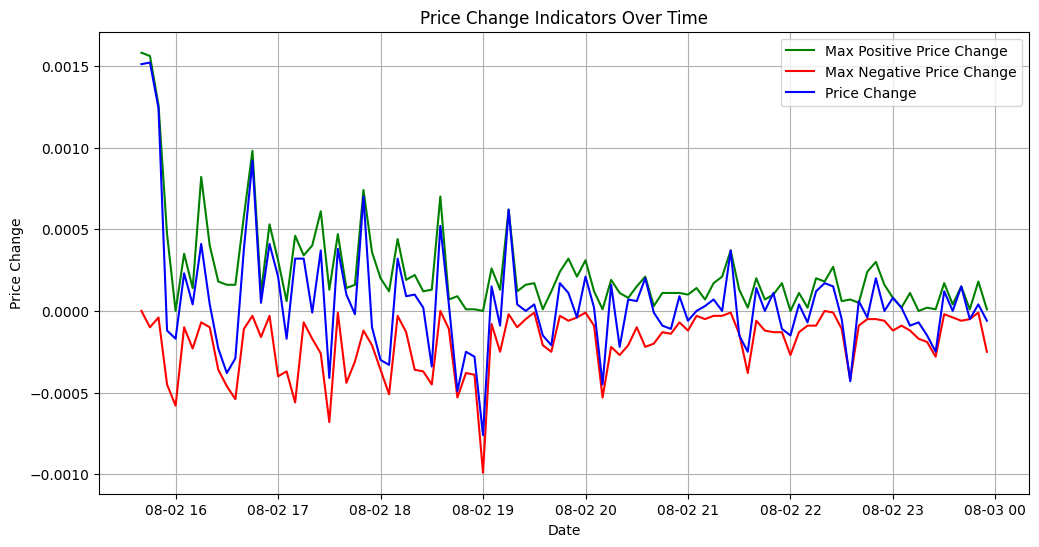

In [107]:
def plot_price_change(data):
    plt.figure(figsize=(12, 6))

    plt.plot(data.index, data['MaxPositivePriceChange'], label='Max Positive Price Change', color='green')
    plt.plot(data.index, -data['MaxNegativePriceChange'], label='Max Negative Price Change', color='red')
    plt.plot(data.index, data['PriceChange'], label='Price Change', color='blue')

    plt.title('Price Change Indicators Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price Change')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_price_change(data[-100:])